This notebook goes from the point where we can follow the growth of a falling and growing
particle to the problem of evaluating the growth rate of the inner core (and doing a reasonably
self consistent calculation). It is very much a work in progress, but with the current rough
approach we would need a particle nucleation rate of about 1E-14 particles/m^.sec to account for
1 km/Myr of inner core growth. This is much larger than we expect (1E-30??).

But there is a lot that I have not done. Specifically:

1. Let pressure, temperature and oxygen content be functions of height above the ICB. This
is easy to fix (just set up functions that return the value on the basis of z, pass these
in as 'args' to the solver and evaluate inside the derivative function). But we need to choose
sensible functions / profiles.
2. Set a sensible spacing between the particles. This should determine rtot and thus should
(maybe) be a function of depth. The rough approach would be to
* Choose a value for rtot and solve the problem as a function of z_init
* Evaluate the number density (and volume density) of particles as a function of depth.
(this needs some thinking about the maths)
* Set rtot as a function and iterate until the density of particles is constant. This
means we wrap the whole thing in a root finding loop. Joy
3. Actually use rootfinding to work out what nucleation rate we need. If nucleation rate
is fixed (w.r.t. P, T & X). This should be easy and fast (we can extract it from the integral over the
sperical shell). However, if we make the rate depend on depth (i.e. P, T and X) things get a bit
more complicated - but I think we can still seperate the integrals.
4. Make the evaluation of the total composition inside rtot consistnet.
* At the moment we use xi in the calculation of the density difference. We should probably
solve this self consistently so we use the 'correct' composition. Needs rootfinding inside the
derivative function. Ouch. 
* Should we exclude the particle itself from the calclation? The logic would be that a particle
has replaced a volume of liquid, so it's only the liquid that needs to match the set composition.
But then I don't think growth would ever stop. Probably depends on what we want to simulate. 
5. Decide exactly what sort of calculation we want to do
6. Calculate F-layer seismic properties. Quite easy once we've done the second bullet under 2
above.
7. Comparison equilibrium calculation. This is going to be massivly different as we are so far
from equilibrium. 
8. See if anything changes as we alter the parameters

Also, note that things get a little computationally expensive from here on in. Even with only
ca.20 function evaluations to get the falling profile of a particle we need to (1) integrate
the results over starting height and (2) probably do that inside a optimisation loop. Maybe do 
(1) in parallel?



In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import boundary_layer

Pr =  0.09075  Sc =  999.9999999999999


In [2]:
initial_particle_size = 1.0E-10 # initial radius, m
t = 5000.0 # temperature, K
p = 330.0 # GPa
xi = 0.95 # Overall composition, mol frac Fe
k0 = 150.0 # growth rate prefactor, m/s
rtot = 1.0 # initial box radius
dl = 1.0E-9 # diffusion
radius_inner_core = 1221.0e3
radius_top_flayer = radius_inner_core + 200.0e3
initial_particle_position = radius_top_flayer
mu = 1.0e-6 # kinematic viscosity
g = 3.7 # ICB gravity - from PREM
start_time = 0 # s
max_time = 1000000 # s

Finished because:  A termination event occurred.


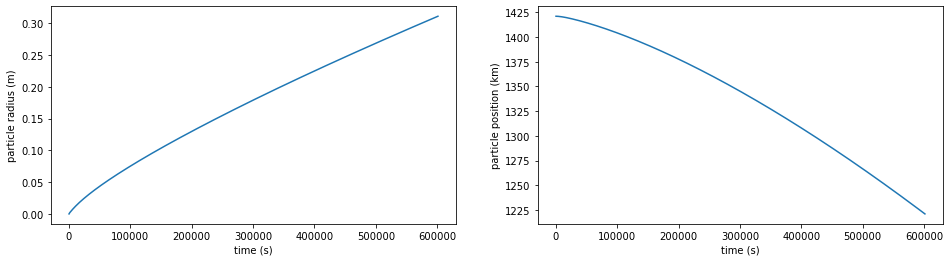

In [3]:
sol = boundary_layer.falling_growing_particle_solution(start_time, max_time, initial_particle_size, initial_particle_position,
                                        xi, rtot, t, p, dl, k0, g, mu, radius_inner_core)

print('Finished because: ', sol.message)
# Interpolate solution (using 5th order polynomial interpolation)
times = np.linspace(sol.sol.ts[0], sol.sol.ts[-1], 500)
rps = sol.sol(times)[0]
lps = sol.sol(times)[1]

# Plot
fig, ax = plt.subplots(ncols=2, figsize=(16,4))
ax[0].plot(times, rps)
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('particle radius (m)')

ax[1].plot(times, lps/1000)
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('particle position (km)')

plt.show()

## How does the final particle radius vary with neucleation height

We ultimatly want to integrate the final volumes of the particles hitting the ICB over the volume
of the starting location (i.e. over the F-layer) with an assumed constant nuclation rate and solve
to find the growth rate ... then check the composition is consistent with what we assumed.

In [4]:
starting_radii = np.linspace(radius_inner_core, radius_top_flayer, 10) 
falling_times = np.zeros_like(starting_radii)
final_volumes = np.zeros_like(starting_radii)

for i, initial_particle_position in enumerate(starting_radii):
    sol = boundary_layer.falling_growing_particle_solution(start_time, max_time, initial_particle_size, 
                                                           initial_particle_position,
                                                           xi, rtot, t, p, dl, k0, g, mu, radius_inner_core)
    falling_times[i] = sol.t[-1]
    final_volumes[i] = 4/3 * np.pi * sol.y[0][-1]**3
    

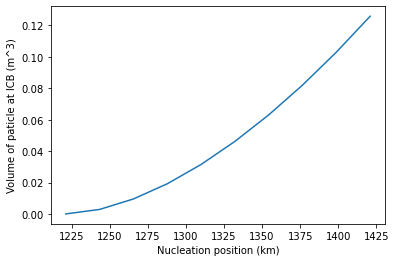

In [5]:
fig, ax = plt.subplots()
ax.plot(starting_radii/1000.0, final_volumes)
ax.set_xlabel('Nucleation position (km)')
ax.set_ylabel('Volume of paticle at ICB (m^3)')
plt.show()

## Inner core growth

We now have a (non-analytical) function, $f(z_0)$ that allows us to evaluate the 
volume of particles reaching the ICB which only depends on the nucleation height ($z_0$)
and a set of other (assumed known) parameters. We can thus write the growth rate
of the inner core by assuming steady state (so the falling time does not matter)
and integrating the volume of material arriving:

$$\frac{dR_{icb}}{dt} = \frac{1}{\mathscr{F} A_{icb}}\int_{z_{icb}}^{z_{top}} 4 \pi z_0^2 f(z_0) \mathscr{N} dz_0 $$

Here $\mathscr{F}$ is the fraction of inner core growth arising from particle
settling, $A_{icb}$ is the area of the surface of the inner core and $\mathscr{N}$
is the particle nucleation rate.

It seems we can proceed in three ways:

1. Find $\frac{\mathscr{N}}{\mathscr{F}}$ that gives 1 km/Myr (or whatever). Evaluate the resulting seismic structure of the F-layer.
2. Use $\mathscr{N}$ (from previous work, and this can then depend on $z$). Assume $\mathscr{F}$ is 1 (or whatever) and compare with F-layer
3. Do a comparison between equilibrium and non-equilibrium case (as close as we can manage).

I'm going to play with 1.

Sorry about symbols - we seem to be running out

Do we need to think about spacing of particles (rtot in the function)?

In [6]:
def inner_core_growth_rate(nuc_rate, xi, rtot, t, p, dl, k0, g, mu, radius_inner_core, 
                           radius_top_flayer, num_layers, start_time, max_time):
    """
    Calculate the inner core growth rate caused by falling particles
    """
    starting_radii = np.linspace(radius_inner_core, radius_top_flayer, num_layers) 
    final_volumes = np.zeros_like(starting_radii)
    for i, initial_particle_position in enumerate(starting_radii):

        sol = boundary_layer.falling_growing_particle_solution(start_time, max_time, initial_particle_size, 
                                                           initial_particle_position,
                                                           xi, rtot, t, p, dl, k0, g, mu, radius_inner_core)
        final_volumes[i] = 4/3 * np.pi * sol.y[0][-1]**3
    
    # Could simplify - 4pis cancel, for example...
    area_icb = 4.0 * np.pi * radius_inner_core**2
    growth_rate = np.trapz(final_volumes * nuc_rate * starting_radii**2 * 4.0 * np.pi, starting_radii) / area_icb
    return growth_rate
    

In [7]:
secinMyr = 60.0*60.0*24.0*365.0*1000000

print('{:^9s} {:^9s} {:^9s}'.format("Nuc rate", "dR/dt", "dR/dt"))
print('{:^9s} {:^9s} {:^9s}'.format("/m^3 /sec", "m/sec", "km/Myr"))

for nuc_rate in [1.0E-5, 1.0E-6, 1.0E-7, 1.0E-8, 1.0E-14]:
    # This is stupid - I don't need to put nuc_rate inside the loop (I don't think)
    growth_rate = inner_core_growth_rate(nuc_rate, xi, rtot, t, p, dl, k0, g, mu, radius_inner_core, 
                                         radius_top_flayer, 10, start_time, max_time)
    print('{: 6.2e} {: 6.2e} {: 6.2e}'.format(nuc_rate, growth_rate, growth_rate/1000 * secinMyr))


Nuc rate    dR/dt     dR/dt  
/m^3 /sec   m/sec    km/Myr  
 1.00e-05  1.17e-01  3.70e+09
 1.00e-06  1.17e-02  3.70e+08
 1.00e-07  1.17e-03  3.70e+07
 1.00e-08  1.17e-04  3.70e+06
 1.00e-14  1.17e-10  3.70e+00


As expected, for $\sim$1 km/Myr growth rate the nucleation rate is far higher than we expect from
theory or atomic scale simulation (1.0E-14 v's 1.0E-30 events / m^3.sec).

I suppose we could work out what this (with most crystalisation directly onto the inner core)
would look like.